## Stock Price Forecasting with Technical Indicators
### Goal: Use linearan LSTM model with technical analysis indicators as the features to try and predict future price movement

In [687]:
#Importing necessary libraries for reading in stock price data, visualization tools, and building ML models
import yfinance as yf
from pandas_datareader import data as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#We will be using sci-kit learn and Keras for the ML model, these two libraries have become the standard framework in Python
#for machine learning.
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

## Step 1: Data Preparation
### - Read in historical stock data
### - Feature engineering to create technical indicators such as MACD, RSI, and OBV
### - Scaling the data to be between 0 and 1
### - Split the data to be 80% training and 20% testing

In [688]:
#To examine technical analysis indicators, we'll read in data about the S&P 500 and focus solely on it to see how 
#technical indicators play a role in stock movement.
technicalDF = pdr.get_data_yahoo('SPY', start = '2001-04-01', end = '2021-04-01')
technicalDF.reset_index(inplace = True)

#It should already be in ascending order by date but using sort_values to confirm.
technicalDF = technicalDF.sort_values(by = ['Date'])
technicalDF

,Date,High,Low,Open,Close,Volume,Adj Close
0,2001-04-02,117.379997,113.800003,116.300003,114.199997,10561000.0,77.831200
1,2001-04-03,114.150002,110.059998,113.980003,110.389999,12836000.0,75.234581
2,2001-04-04,112.099998,109.300003,110.570000,110.849998,14884300.0,75.548073
3,2001-04-05,115.489998,112.500000,113.300003,115.050003,21522800.0,78.410530
4,2001-04-06,114.400002,112.059998,113.989998,113.300003,14937800.0,77.217880
...,...,...,...,...,...,...,...
5027,2021-03-26,396.410004,390.290009,390.929993,395.980011,113023400.0,395.980011
5028,2021-03-29,396.750000,392.809998,394.399994,395.779999,108107600.0,395.779999
5029,2021-03-30,395.450012,393.019989,394.420013,394.730011,76262200.0,394.730011
5030,2021-03-31,398.000000,395.309998,395.339996,396.329987,112734200.0,396.329987


In [689]:
#Examining the datatypes of the dataframe to confirm everything imported correctly
technicalDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5032 entries, 0 to 5031
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5032 non-null   datetime64[ns]
 1   High       5032 non-null   float64       
 2   Low        5032 non-null   float64       
 3   Open       5032 non-null   float64       
 4   Close      5032 non-null   float64       
 5   Volume     5032 non-null   float64       
 6   Adj Close  5032 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 314.5 KB


In [690]:
#Describing the data to get an idea of the distribution of the data
technicalDF.describe()

,High,Low,Open,Close,Volume,Adj Close
count,5032.000000,5032.000000,5032.000000,5032.000000,5.032000e+03,5032.000000
mean,170.729036,168.677182,169.746874,169.760211,1.177482e+08,146.370934
std,72.929606,72.334375,72.656070,72.659755,9.637642e+07,79.880481
min,70.000000,67.099998,67.949997,68.110001,3.303100e+06,53.329201
25%,116.400002,114.627499,115.472502,115.675001,5.394080e+07,86.146654
50%,139.555000,137.899994,138.620003,138.665001,8.756885e+07,109.575436
75%,210.979996,209.282497,210.152496,210.255001,1.537806e+08,188.683949
max,400.670013,398.179993,398.399994,400.609985,8.710263e+08,400.609985


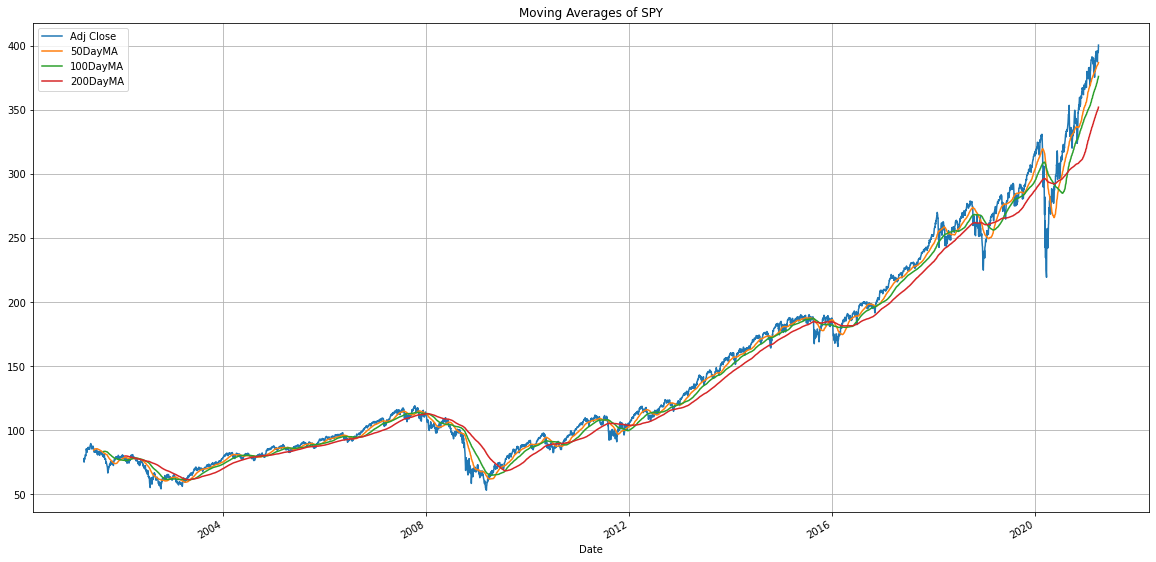

In [691]:
#One of the most popular tehnical indicators is the Simple Moving Average. It's exactly what it sounds like, it's a 
#moving average over a specified period of time. The 4 most popular time frames are the 200-day SMA, 100-day SMA, 
#50-day SMA, and the 14-day SMA.

#Adding the various moving averages to our dataframe and then plotting it.
technicalDF['14DayMA'] = technicalDF['Adj Close'].transform(lambda x: x.rolling(window = 14).mean())
technicalDF['50DayMA'] = technicalDF['Adj Close'].transform(lambda x: x.rolling(window = 50).mean())
technicalDF['100DayMA'] = technicalDF['Adj Close'].transform(lambda x: x.rolling(window = 100).mean())
technicalDF['200DayMA'] = technicalDF['Adj Close'].transform(lambda x: x.rolling(window = 200).mean())
    
#Plotting the adjusted close price of SPY along with the 50, 100, and 200 day moving averages.
technicalDF[['Date', 'Adj Close', '50DayMA', '100DayMA', '200DayMA']].plot(x = 'Date', figsize = (20, 10), 
                                                                    title = 'Moving Averages of SPY')
plt.grid()
plt.show()

#Whenever the price moves above a moving average, that's typically a "Buy" signal and when it goes below,
#it's a "Sell" signal.

In [692]:
#Examining the new columns in the dataframe
technicalDF

,Date,High,Low,Open,Close,Volume,Adj Close,14DayMA,50DayMA,100DayMA,200DayMA
0,2001-04-02,117.379997,113.800003,116.300003,114.199997,10561000.0,77.831200,NaN,NaN,NaN,NaN
1,2001-04-03,114.150002,110.059998,113.980003,110.389999,12836000.0,75.234581,NaN,NaN,NaN,NaN
2,2001-04-04,112.099998,109.300003,110.570000,110.849998,14884300.0,75.548073,NaN,NaN,NaN,NaN
3,2001-04-05,115.489998,112.500000,113.300003,115.050003,21522800.0,78.410530,NaN,NaN,NaN,NaN
4,2001-04-06,114.400002,112.059998,113.989998,113.300003,14937800.0,77.217880,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5027,2021-03-26,396.410004,390.290009,390.929993,395.980011,113023400.0,395.980011,391.421550,385.411678,373.760663,350.235584
5028,2021-03-29,396.750000,392.809998,394.399994,395.779999,108107600.0,395.779999,392.126831,385.782789,374.441212,350.735157
5029,2021-03-30,395.450012,393.019989,394.420013,394.730011,76262200.0,394.730011,392.585532,386.187919,375.053398,351.211765
5030,2021-03-31,398.000000,395.309998,395.339996,396.329987,112734200.0,396.329987,392.877295,386.566241,375.607047,351.682396


<AxesSubplot:title={'center':'MACD and Signal Line'}, xlabel='Date'>

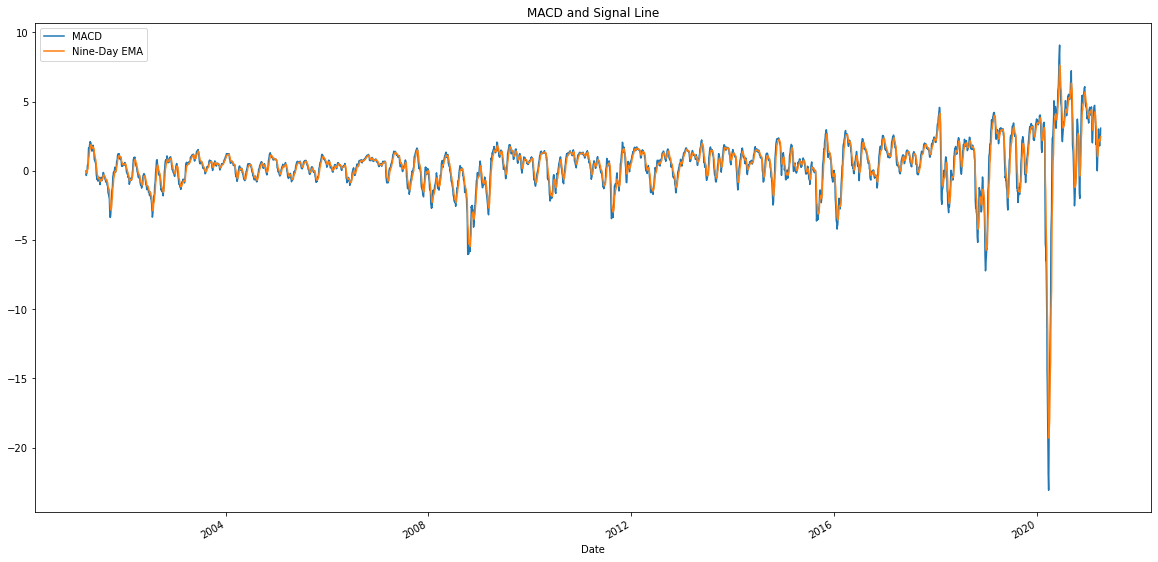

In [693]:
#Another popular technical analysis indicator is the moving average convergence divergence (MACD). MACD is cacluated 
#by subtracting the 12 day exponential moving average from the 26 day EMA. Once the MACD moves above 0 for a 
#sustained period of time, that's a buy signal. When it goes below 0 for a sustained period of time, that's a bearish
#signal.

#For more info on exponential moving averages, check out https://www.investopedia.com/terms/e/ema.asp.
technicalDF['Twelve-Day EMA'] = technicalDF['Adj Close'].ewm(span = 12, adjust = False).mean()
technicalDF['Twenty Six-Day EMA'] = technicalDF['Adj Close'].ewm(span = 26, adjust = False).mean()
technicalDF['MACD'] = technicalDF['Twelve-Day EMA'] - technicalDF['Twenty Six-Day EMA']
technicalDF['Nine-Day EMA'] = technicalDF['MACD'].ewm(span = 9, adjust = False).mean() 
 
#Looking at just the MACD and signal line to get a better look
technicalDF[['Date', 'MACD', 'Nine-Day EMA']].plot(x = 'Date', figsize = (20, 10), 
                                                                    title = 'MACD and Signal Line')

In [694]:
#Examining the new column
technicalDF

,Date,High,Low,Open,Close,Volume,Adj Close,14DayMA,50DayMA,100DayMA,200DayMA,Twelve-Day EMA,Twenty Six-Day EMA,MACD,Nine-Day EMA
0,2001-04-02,117.379997,113.800003,116.300003,114.199997,10561000.0,77.831200,NaN,NaN,NaN,NaN,77.831200,77.831200,0.000000,0.000000
1,2001-04-03,114.150002,110.059998,113.980003,110.389999,12836000.0,75.234581,NaN,NaN,NaN,NaN,77.431720,77.638858,-0.207138,-0.041428
2,2001-04-04,112.099998,109.300003,110.570000,110.849998,14884300.0,75.548073,NaN,NaN,NaN,NaN,77.141928,77.483985,-0.342057,-0.101553
3,2001-04-05,115.489998,112.500000,113.300003,115.050003,21522800.0,78.410530,NaN,NaN,NaN,NaN,77.337098,77.552618,-0.215520,-0.124347
4,2001-04-06,114.400002,112.059998,113.989998,113.300003,14937800.0,77.217880,NaN,NaN,NaN,NaN,77.318756,77.527822,-0.209066,-0.141291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5027,2021-03-26,396.410004,390.290009,390.929993,395.980011,113023400.0,395.980011,391.421550,385.411678,373.760663,350.235584,390.731523,388.577276,2.154247,2.138392
5028,2021-03-29,396.750000,392.809998,394.399994,395.779999,108107600.0,395.779999,392.126831,385.782789,374.441212,350.735157,391.508212,389.110811,2.397401,2.190194
5029,2021-03-30,395.450012,393.019989,394.420013,394.730011,76262200.0,394.730011,392.585532,386.187919,375.053398,351.211765,392.003873,389.527048,2.476825,2.247520
5030,2021-03-31,398.000000,395.309998,395.339996,396.329987,112734200.0,396.329987,392.877295,386.566241,375.607047,351.682396,392.669429,390.030969,2.638460,2.325708


In [695]:
#The next indicator to look at is the relative strength index (RSI). It ranges from 0-100 and when it's above 70,
#it indicates that the stock may be overbought and due for a correction or is simply just having a very strong uptrend.
#When it goes below 30, the stocck may be oversold and due for a comeback.

#For more information on how the RSI is calculated, check out https://www.investopedia.com/terms/r/rsi.asp
def RSI(dataframe, timeWindow):
    priceDifference = dataframe.diff(1).dropna()
    positiveChange = priceDifference * 0
    negativeChange = priceDifference * 0 #Initializing the values

    #If the difference in price is positive, accept it, otherwise the value is 0.
    positiveChange[priceDifference > 0] = priceDifference[priceDifference > 0]
    #If the difference in price is negative, accept it, otherwise the value is 0.
    negativeChange[priceDifference < 0] = priceDifference[priceDifference < 0]

    #Calculating the EMA for 14 days
    positiveAverage = positiveChange.ewm(com = timeWindow - 1, min_periods = timeWindow).mean()
    negativeAverage = negativeChange.ewm(com = timeWindow - 1, min_periods = timeWindow).mean()
    #Calculating the relative strength (average gain / average loss)
    relativeStrength = abs(positiveAverage / negativeAverage)
    
    #Implementing the RSI formula
    RSI = 100 - (100 / (1 + relativeStrength))
    return RSI

#Adding the RSI column to the dataframe
technicalDF['RSI'] = RSI(technicalDF['Adj Close'], 14)
technicalDF

,Date,High,Low,Open,Close,Volume,Adj Close,14DayMA,50DayMA,100DayMA,200DayMA,Twelve-Day EMA,Twenty Six-Day EMA,MACD,Nine-Day EMA,RSI
0,2001-04-02,117.379997,113.800003,116.300003,114.199997,10561000.0,77.831200,NaN,NaN,NaN,NaN,77.831200,77.831200,0.000000,0.000000,NaN
1,2001-04-03,114.150002,110.059998,113.980003,110.389999,12836000.0,75.234581,NaN,NaN,NaN,NaN,77.431720,77.638858,-0.207138,-0.041428,NaN
2,2001-04-04,112.099998,109.300003,110.570000,110.849998,14884300.0,75.548073,NaN,NaN,NaN,NaN,77.141928,77.483985,-0.342057,-0.101553,NaN
3,2001-04-05,115.489998,112.500000,113.300003,115.050003,21522800.0,78.410530,NaN,NaN,NaN,NaN,77.337098,77.552618,-0.215520,-0.124347,NaN
4,2001-04-06,114.400002,112.059998,113.989998,113.300003,14937800.0,77.217880,NaN,NaN,NaN,NaN,77.318756,77.527822,-0.209066,-0.141291,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5027,2021-03-26,396.410004,390.290009,390.929993,395.980011,113023400.0,395.980011,391.421550,385.411678,373.760663,350.235584,390.731523,388.577276,2.154247,2.138392,59.364097
5028,2021-03-29,396.750000,392.809998,394.399994,395.779999,108107600.0,395.779999,392.126831,385.782789,374.441212,350.735157,391.508212,389.110811,2.397401,2.190194,59.071509
5029,2021-03-30,395.450012,393.019989,394.420013,394.730011,76262200.0,394.730011,392.585532,386.187919,375.053398,351.211765,392.003873,389.527048,2.476825,2.247520,57.470152
5030,2021-03-31,398.000000,395.309998,395.339996,396.329987,112734200.0,396.329987,392.877295,386.566241,375.607047,351.682396,392.669429,390.030969,2.638460,2.325708,59.281555


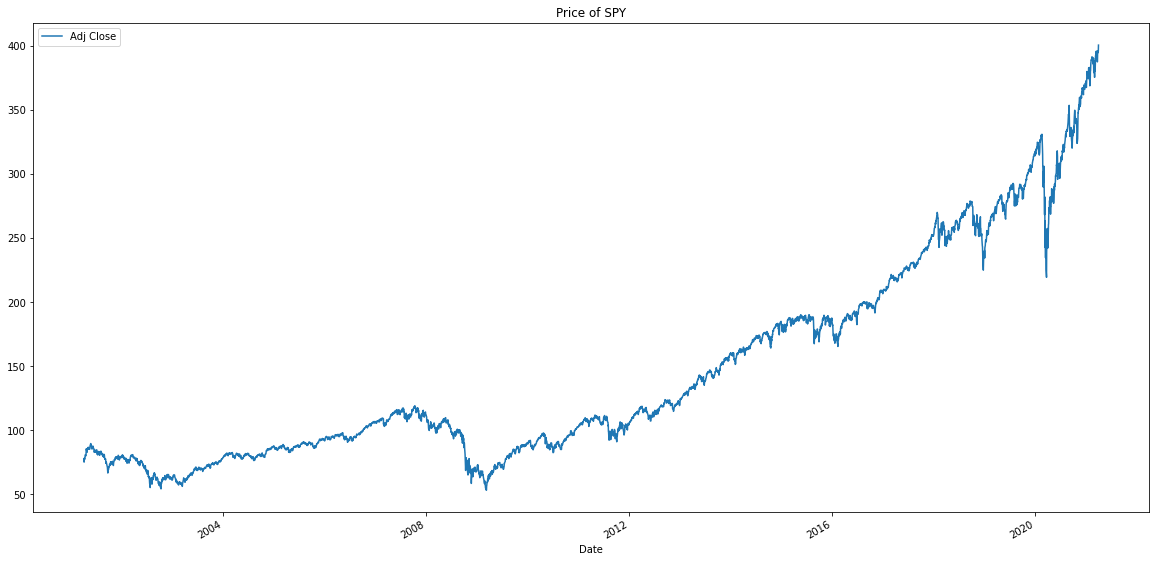

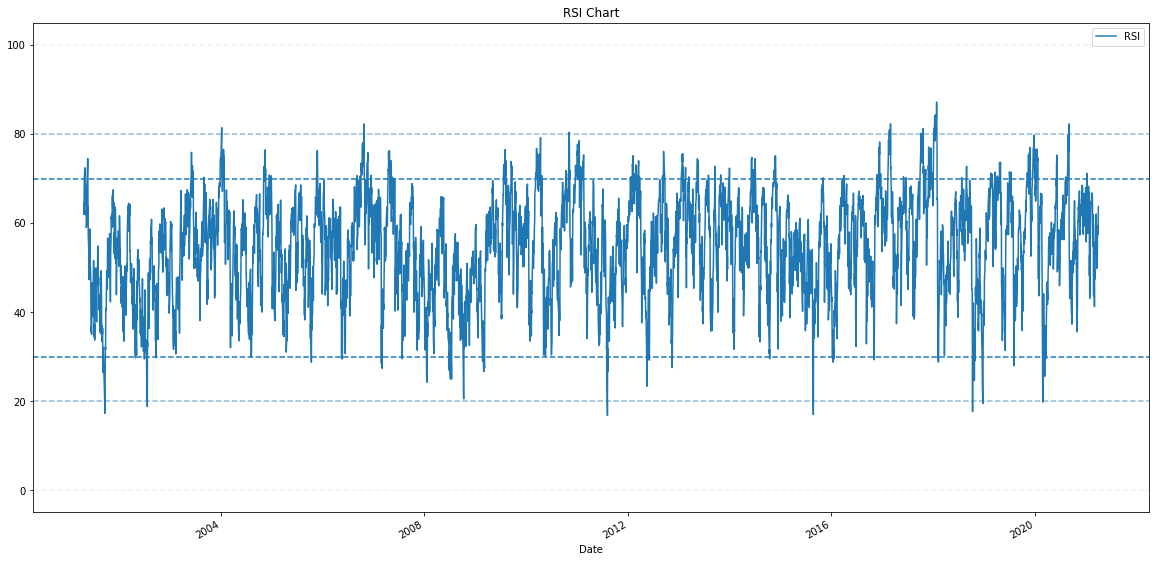

In [696]:
#Plotting two graphs: one of the price of SPY and one of the RSI along with key thresholds
technicalDF[['Date', 'Adj Close']].plot(x = 'Date', figsize = (20, 10), 
                                               title = 'Price of SPY')
plt.show()

technicalDF[['Date', 'RSI']].plot(x = 'Date', figsize = (20, 10), 
                                  title = 'RSI Chart')

#Adding lines for key thresholds
plt.axhline(0, linestyle='--', alpha=0.1)
plt.axhline(20, linestyle='--', alpha=0.5)
plt.axhline(30, linestyle='--')
plt.axhline(70, linestyle='--')
plt.axhline(80, linestyle='--', alpha=0.5)
plt.axhline(100, linestyle='--', alpha=0.1)
plt.show()

In [697]:
#The last technical indicator to look at is On-Balance Volume. This indicator looks at cumulative volume of buying
#and selling. Ideally, a rising on balance volume should indicate a rising price. If the volume is increasing but
#the price is staying flat, that may be indicative that the stock is reaching a top.

#Creating a function to calculate OBV
def OBV(dataframe):
    OBV = []
    OBV.append(0) #Initializing an empty list with the first value being 0 (since there's no volume yet)
    
    #Looping through the data and calculating a cumulative volume if it increases and decreasing it when necessary
    for i in range(1, len(dataframe)):
        if dataframe[i] > dataframe[i - 1]: #If the volume is higher than the previous day
            OBV.append(OBV[-1] + dataframe[i]) #Add the previous volume to current volume
        elif dataframe[i] < dataframe[i -1]: #If the volume is lower than the previous day
            OBV.append(OBV[-1] - dataframe[1]) #Subtract the current volume from yesterday's volume
        else:
            OBV.append(OBV[-1])
    return OBV

#Adding a new column to the dataframe for the on-balance volume
technicalDF['OBV'] = OBV(technicalDF['Volume'])
#Also adding a column for a 21 day OBV EMA to see if the current volume is better or worse than the average volume
technicalDF['OBV_21DayEMA'] = technicalDF['OBV'].ewm(span = 21).mean()
technicalDF

,Date,High,Low,Open,Close,Volume,Adj Close,14DayMA,50DayMA,100DayMA,200DayMA,Twelve-Day EMA,Twenty Six-Day EMA,MACD,Nine-Day EMA,RSI,OBV,OBV_21DayEMA
0,2001-04-02,117.379997,113.800003,116.300003,114.199997,10561000.0,77.831200,NaN,NaN,NaN,NaN,77.831200,77.831200,0.000000,0.000000,NaN,0.000000e+00,0.000000e+00
1,2001-04-03,114.150002,110.059998,113.980003,110.389999,12836000.0,75.234581,NaN,NaN,NaN,NaN,77.431720,77.638858,-0.207138,-0.041428,NaN,1.283600e+07,6.723619e+06
2,2001-04-04,112.099998,109.300003,110.570000,110.849998,14884300.0,75.548073,NaN,NaN,NaN,NaN,77.141928,77.483985,-0.342057,-0.101553,NaN,2.772030e+07,1.439914e+07
3,2001-04-05,115.489998,112.500000,113.300003,115.050003,21522800.0,78.410530,NaN,NaN,NaN,NaN,77.337098,77.552618,-0.215520,-0.124347,NaN,4.924310e+07,2.439210e+07
4,2001-04-06,114.400002,112.059998,113.989998,113.300003,14937800.0,77.217880,NaN,NaN,NaN,NaN,77.318756,77.527822,-0.209066,-0.141291,NaN,3.640710e+07,2.727349e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5027,2021-03-26,396.410004,390.290009,390.929993,395.980011,113023400.0,395.980011,391.421550,385.411678,373.760663,350.235584,390.731523,388.577276,2.154247,2.138392,59.364097,2.958595e+11,2.954182e+11
5028,2021-03-29,396.750000,392.809998,394.399994,395.779999,108107600.0,395.779999,392.126831,385.782789,374.441212,350.735157,391.508212,389.110811,2.397401,2.190194,59.071509,2.958467e+11,2.954572e+11
5029,2021-03-30,395.450012,393.019989,394.420013,394.730011,76262200.0,394.730011,392.585532,386.187919,375.053398,351.211765,392.003873,389.527048,2.476825,2.247520,57.470152,2.958339e+11,2.954914e+11
5030,2021-03-31,398.000000,395.309998,395.339996,396.329987,112734200.0,396.329987,392.877295,386.566241,375.607047,351.682396,392.669429,390.030969,2.638460,2.325708,59.281555,2.959466e+11,2.955328e+11


<AxesSubplot:title={'center':'On-Balance Volume(OBV) with the 21-Day OBV Average'}, xlabel='Date'>

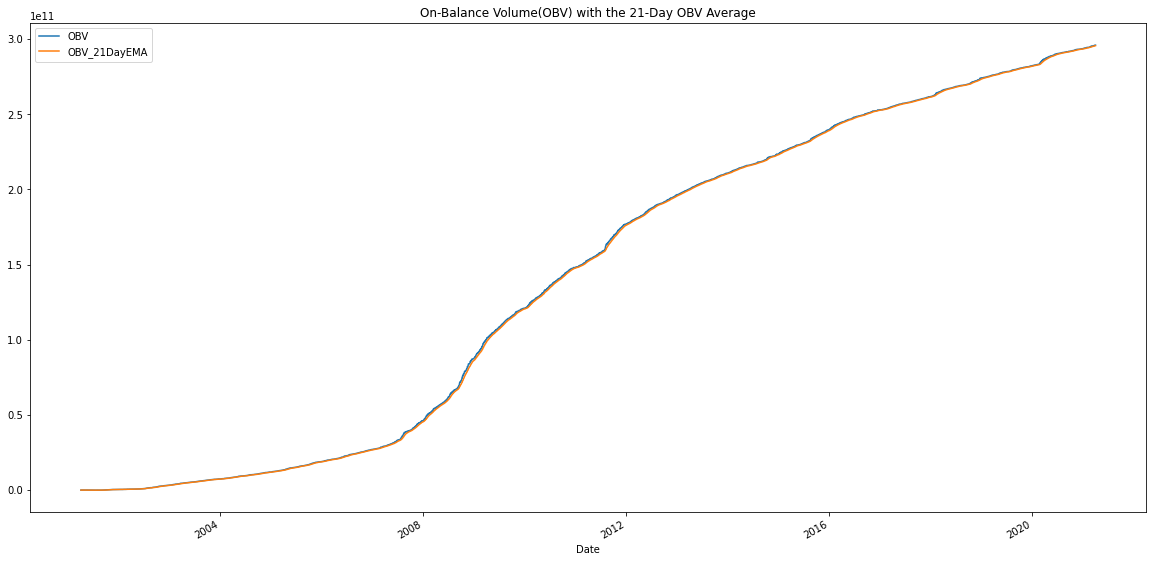

In [698]:
#Plotting the OBV and the 21 day OBV EMA. When the OBV passes the EMA, that can be considered a buy signal.
#When the OBV falls below the EMA, it's considered a sell signal.
technicalDF[['Date', 'OBV', 'OBV_21DayEMA']].plot(x = 'Date', figsize = (20, 10), 
                                                  title = 'On-Balance Volume(OBV) with the 21-Day OBV Average')

In [699]:
#Adding the target column to the dataframe
daysAhead = 1
technicalDF['Target'] = technicalDF['Adj Close'].shift(-daysAhead) #Setting the target variable to the price 1 day later


#Removing the last row since it will be null
technicalDF = technicalDF[:-daysAhead]

#Showing the new dataframe
technicalDF

,Date,High,Low,Open,Close,Volume,Adj Close,14DayMA,50DayMA,100DayMA,200DayMA,Twelve-Day EMA,Twenty Six-Day EMA,MACD,Nine-Day EMA,RSI,OBV,OBV_21DayEMA,Target
0,2001-04-02,117.379997,113.800003,116.300003,114.199997,10561000.0,77.831200,NaN,NaN,NaN,NaN,77.831200,77.831200,0.000000,0.000000,NaN,0.000000e+00,0.000000e+00,75.234581
1,2001-04-03,114.150002,110.059998,113.980003,110.389999,12836000.0,75.234581,NaN,NaN,NaN,NaN,77.431720,77.638858,-0.207138,-0.041428,NaN,1.283600e+07,6.723619e+06,75.548073
2,2001-04-04,112.099998,109.300003,110.570000,110.849998,14884300.0,75.548073,NaN,NaN,NaN,NaN,77.141928,77.483985,-0.342057,-0.101553,NaN,2.772030e+07,1.439914e+07,78.410530
3,2001-04-05,115.489998,112.500000,113.300003,115.050003,21522800.0,78.410530,NaN,NaN,NaN,NaN,77.337098,77.552618,-0.215520,-0.124347,NaN,4.924310e+07,2.439210e+07,77.217880
4,2001-04-06,114.400002,112.059998,113.989998,113.300003,14937800.0,77.217880,NaN,NaN,NaN,NaN,77.318756,77.527822,-0.209066,-0.141291,NaN,3.640710e+07,2.727349e+07,78.076530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5026,2021-03-25,390.549988,383.899994,385.980011,389.700012,116128600.0,389.700012,390.313967,385.063082,373.041788,349.825509,389.777253,387.985057,1.792196,2.134428,52.505397,2.958724e+11,2.953741e+11,395.980011
5027,2021-03-26,396.410004,390.290009,390.929993,395.980011,113023400.0,395.980011,391.421550,385.411678,373.760663,350.235584,390.731523,388.577276,2.154247,2.138392,59.364097,2.958595e+11,2.954182e+11,395.779999
5028,2021-03-29,396.750000,392.809998,394.399994,395.779999,108107600.0,395.779999,392.126831,385.782789,374.441212,350.735157,391.508212,389.110811,2.397401,2.190194,59.071509,2.958467e+11,2.954572e+11,394.730011
5029,2021-03-30,395.450012,393.019989,394.420013,394.730011,76262200.0,394.730011,392.585532,386.187919,375.053398,351.211765,392.003873,389.527048,2.476825,2.247520,57.470152,2.958339e+11,2.954914e+11,396.329987


In [700]:
#Removing the first 200 rows and selecting only the columns we want to use
technicalDF = technicalDF[['Date', 'OBV', 'OBV_21DayEMA', '14DayMA', '50DayMA', '100DayMA', '200DayMA', 'MACD', 'RSI', 'Target']][200:]
technicalDF

,Date,OBV,OBV_21DayEMA,14DayMA,50DayMA,100DayMA,200DayMA,MACD,RSI,Target
200,2002-01-23,4.542424e+08,4.457926e+08,79.115004,78.880426,76.562271,80.050867,-0.236929,45.074445,78.188103
201,2002-01-24,4.414064e+08,4.453939e+08,78.954704,78.897585,76.530683,80.065634,-0.247004,46.622124,78.167465
202,2002-01-25,4.542171e+08,4.461960e+08,78.754575,78.923799,76.503741,80.078731,-0.253729,46.501252,78.380875
203,2002-01-28,4.413811e+08,4.457583e+08,78.610503,78.919705,76.490757,80.078583,-0.239082,48.002513,75.916405
204,2002-01-29,4.691019e+08,4.478804e+08,78.303676,78.864813,76.460237,80.072075,-0.421478,35.584166,77.010986
...,...,...,...,...,...,...,...,...,...,...
5026,2021-03-25,2.958724e+11,2.953741e+11,390.313967,385.063082,373.041788,349.825509,1.792196,52.505397,395.980011
5027,2021-03-26,2.958595e+11,2.954182e+11,391.421550,385.411678,373.760663,350.235584,2.154247,59.364097,395.779999
5028,2021-03-29,2.958467e+11,2.954572e+11,392.126831,385.782789,374.441212,350.735157,2.397401,59.071509,394.730011
5029,2021-03-30,2.958339e+11,2.954914e+11,392.585532,386.187919,375.053398,351.211765,2.476825,57.470152,396.329987


In [701]:
#Using the MinMaxScaler from sklearn to restrict the values to be from 0 to 1
scaler = MinMaxScaler(feature_range = (0, 1))
scaledTechnicalDF = scaler.fit_transform(technicalDF.drop(columns = 'Date')) #Not including the data field when scaling

#Examining the scaled dataframe
scaledTechnicalDF

array([[4.35230884e-05, 1.35129353e-06, 6.61946836e-02, ...,
        7.10270742e-01, 4.01652095e-01, 7.15815648e-02],
       [8.56160837e-08, 0.00000000e+00, 6.57176071e-02, ...,
        7.09957463e-01, 4.23639702e-01, 7.15221388e-02],
       [4.34374723e-05, 2.71820965e-06, 6.51219927e-02, ...,
        7.09748353e-01, 4.21922498e-01, 7.21366543e-02],
       ...,
       [9.99661941e-01, 9.99743705e-01, 9.97766502e-01, ...,
        7.92183990e-01, 6.00505918e-01, 9.83068529e-01],
       [9.99618504e-01, 9.99859763e-01, 9.99131667e-01, ...,
        7.94653653e-01, 5.77755722e-01, 9.87675682e-01],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        7.99679603e-01, 6.03490003e-01, 1.00000000e+00]])

In [702]:
#Setting the features (predictors) to be the low, high, open, close, and volume 
#and setting the target to be the opening price for the next day
features = scaledTechnicalDF[:, :8] #All rows and all columns up to the target
target = scaledTechnicalDF[:, 8:] #All rows and just the target column

#Printing out the shape on both to confirm that we're getting the right data
print(features.shape)
print(target.shape)

(4831, 8)
(4831, 1)


In [703]:
#Splitting the data into the first 80% of the dates for the training set and the remaining 20% for testing
#We can't randomly choose records in the dataset due to it being a time series
split = int(0.80 * len(features))
featuresTrain = features[:split]
targetTrain = target[:split]
featuresTest = features[split:]
targetTest = target[split:]

#Printing out the shapes to make sure we have the right amount of data in each set
print(featuresTrain.shape)
print(featuresTest.shape)
print(targetTrain.shape)
print(targetTest.shape)

(3864, 8)
(967, 8)
(3864, 1)
(967, 1)


### Step 2: Linear Regression
#### What is linear regression?
####     - Linear regression seeks to find the relationship between a dependent variable and one or more indepent variables
####     - For our example, the price 10 days later is the dependent variable and the independent variables are today's price and volume
#### How does linear regression work?
####     - The most common way a linear model is calculated is by finding the sum of the least squares.
####     - The sum of the least squares works by calculating the distance of each data point to the line you're trying to draw through the data points.
![image-2.png](attachment:image-2.png)

In [704]:
#Calling the LinearRegression() function to fit and train our model
linearModel = LinearRegression()
linearModel.fit(featuresTrain, targetTrain)
print(linearModel.coef_)

[[-0.55315786  0.55648469  0.2286721   0.66171937  0.03944864  0.00996757
   0.17793215  0.02138579]]


In [705]:
#Making predictions using the testing set
lrPredictions = linearModel.predict(featuresTest)

#Printing the mean squared error and R2 score
print("The mean squared error is: " + str(mean_squared_error(targetTest, lrPredictions)))
print("The R2 score is: " + str(r2_score(targetTest, lrPredictions)))

The mean squared error is: 0.00024044073530638565
The R2 score is: 0.984116142112066


In [706]:
#Creating a new dataframe for comparison purposes with original and predicted prices
comparisonDF = technicalDF[['Date']][len(technicalDF) - len(lrPredictions):]

#Adding the predictions to the dataframe
predictedLinearPrices = []
for i in lrPredictions:
    predictedLinearPrices.append(i[0])
comparisonDF['Prediction Price'] = predictedLinearPrices

#Getting the original prices
originalPrices = []
for i in targetTest:
    originalPrices.append(i)
comparisonDF['Original Prices'] = np.asarray(originalPrices)


#Showing the new dataframe
comparisonDF

,Date,Prediction Price,Original Prices
4064,2017-05-30,0.491317,0.491909
4065,2017-05-31,0.491509,0.497042
4066,2017-06-01,0.494871,0.499208
4067,2017-06-02,0.496977,0.498727
4068,2017-06-05,0.497826,0.496641
...,...,...,...
5026,2021-03-25,0.965096,0.986668
5027,2021-03-26,0.970854,0.986092
5028,2021-03-29,0.973541,0.983069
5029,2021-03-30,0.974808,0.987676


<AxesSubplot:title={'center':'Original Prices vs Predicted Prices'}, xlabel='Date'>

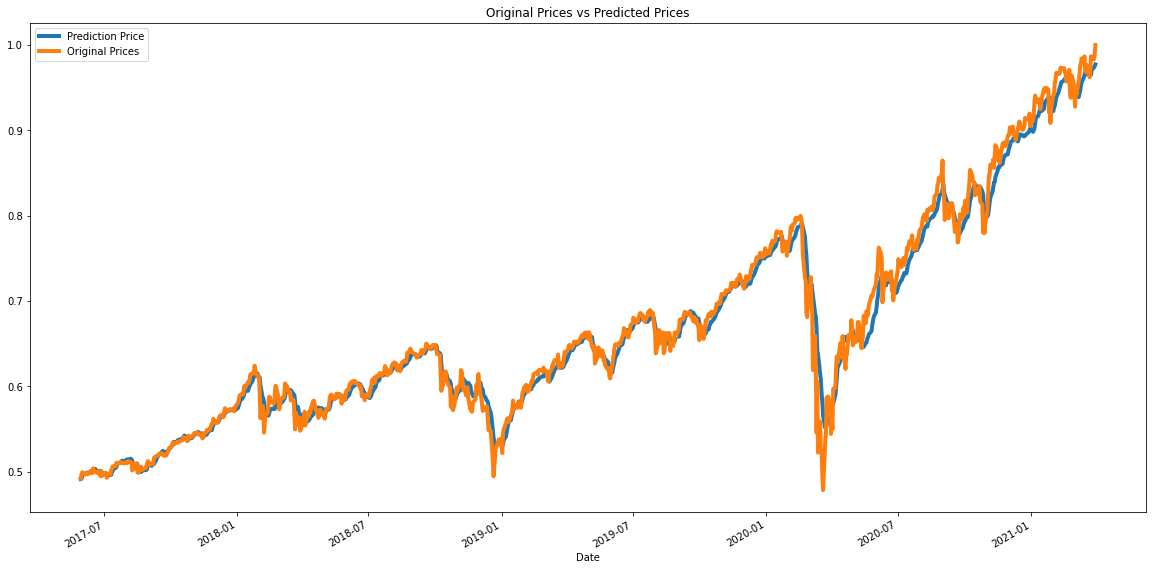

In [707]:
#Using pyplot to compare the original and predicted prices
comparisonDF.plot(x = 'Date', figsize = (20, 10), linewidth = 4, 
             title = 'Original Prices vs Predicted Prices')

### Step 3: LSTM Neural Network
#### How does a LSTM work?
####     - LSTM stand for "long short term memory" and is a type of recurrent neural network
####     - LSTM's work by feeding back the output of one layer at time "t" to the input of the same network layer "t + 1"
![image.png](attachment:image.png)
#### Why choose an LSTM?
####     - These models aren't only capable of accepting single inputs such as images or numbers but can accept entire sequences of numbers or text.
####     - LSTMs solve the "vanishing gradient" problem found in other recurrent neural networks which is when gradients can get closer and closer to 0 and no longer updates the weight.
####     - LSTMs can remember information for an arbitrary amount of time and contain gates that decide whether data can flow through them or not.
#### Excellent resource on learning more about LSTM: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [708]:
#We have to change the shape of the features arrays to be 3 dimensional in order to feed into the LSTM neural network
featuresTrain = np.reshape(featuresTrain, (featuresTrain.shape[0], featuresTrain.shape[1], 1))
featuresTest = np.reshape(featuresTest, (featuresTest.shape[0], featuresTest.shape[1], 1))
#targetTrain = np.reshape(targetTrain, (targetTrain.shape[0], targetTrain.shape[1], 1))

#Showing the shapes of the new datasets
print(featuresTrain.shape)
print(featuresTest.shape)

(3864, 8, 1)
(967, 8, 1)


In [709]:
#Building the LSTM Model
LSTMModel = Sequential()

#Adding an input layer, three hiden layers, and an output layer
LSTMModel.add(LSTM(units = 150, return_sequences = True, input_shape = (featuresTrain.shape[1], featuresTrain.shape[2])))
LSTMModel.add(Dropout(0.2)) #Dropping 20% of the neurons after each layer to avoid overfitting
LSTMModel.add(LSTM(units = 150, return_sequences = True))
LSTMModel.add(Dropout(0.2))
LSTMModel.add(LSTM(units = 150, return_sequences = True))
LSTMModel.add(Dropout(0.2))
LSTMModel.add(Dense(units = 1, activation = 'linear'))

#Compiling and fitting the model
LSTMModel.compile(optimizer = 'adam', loss = 'mean_squared_error')
LSTMModel.fit(featuresTrain, targetTrain, epochs = 20, batch_size = 32)
LSTMModel.summary()

Epoch 1/20
121/121 [==============================] - 2s 17ms/step - loss: 0.0069
Epoch 2/20
121/121 [==============================] - 2s 16ms/step - loss: 0.0033
Epoch 3/20
121/121 [==============================] - 2s 16ms/step - loss: 0.0025
Epoch 4/20
121/121 [==============================] - 2s 16ms/step - loss: 0.0021
Epoch 5/20
121/121 [==============================] - 2s 17ms/step - loss: 0.0020
Epoch 6/20
121/121 [==============================] - 2s 18ms/step - loss: 0.0018
Epoch 7/20
121/121 [==============================] - 2s 16ms/step - loss: 0.0017
Epoch 8/20
121/121 [==============================] - 2s 16ms/step - loss: 0.0016
Epoch 9/20
121/121 [==============================] - 2s 17ms/step - loss: 0.0014
Epoch 10/20
121/121 [==============================] - 2s 16ms/step - loss: 0.0014
Epoch 11/20
121/121 [==============================] - 2s 16ms/step - loss: 0.0012
Epoch 12/20
121/121 [==============================] - 2s 16ms/step - loss: 0.0012
Epoch 13/20
1

In [713]:
#Predicting future stock prices
LSTMPredictions = LSTMModel.predict(featuresTest)
predictedLSTMPrices = []
for i in LSTMPredictions:
    predictedLSTMPrices.append(i[2])

In [714]:
#Creating a new dataframe for comparison purposes with original and predicted prices
predictionDF = technicalDF[['Date']][len(technicalDF) - len(LSTMPredictions):]
predictionDF['Predicted Prices'] = np.asarray(predictedLSTMPrices)

#Getting the original prices
originalPrices = []
for i in targetTest:
    originalPrices.append(i)
predictionDF['Original Prices'] = np.asarray(originalPrices)


#Showing the new dataframe
predictionDF

,Date,Predicted Prices,Original Prices
4064,2017-05-30,0.456693,0.491909
4065,2017-05-31,0.456938,0.497042
4066,2017-06-01,0.457254,0.499208
4067,2017-06-02,0.457778,0.498727
4068,2017-06-05,0.458073,0.496641
...,...,...,...
5026,2021-03-25,0.938146,0.986668
5027,2021-03-26,0.943541,0.986092
5028,2021-03-29,0.946982,0.983069
5029,2021-03-30,0.949214,0.987676


<AxesSubplot:title={'center':'Original Prices vs Predicted Prices'}, xlabel='Date'>

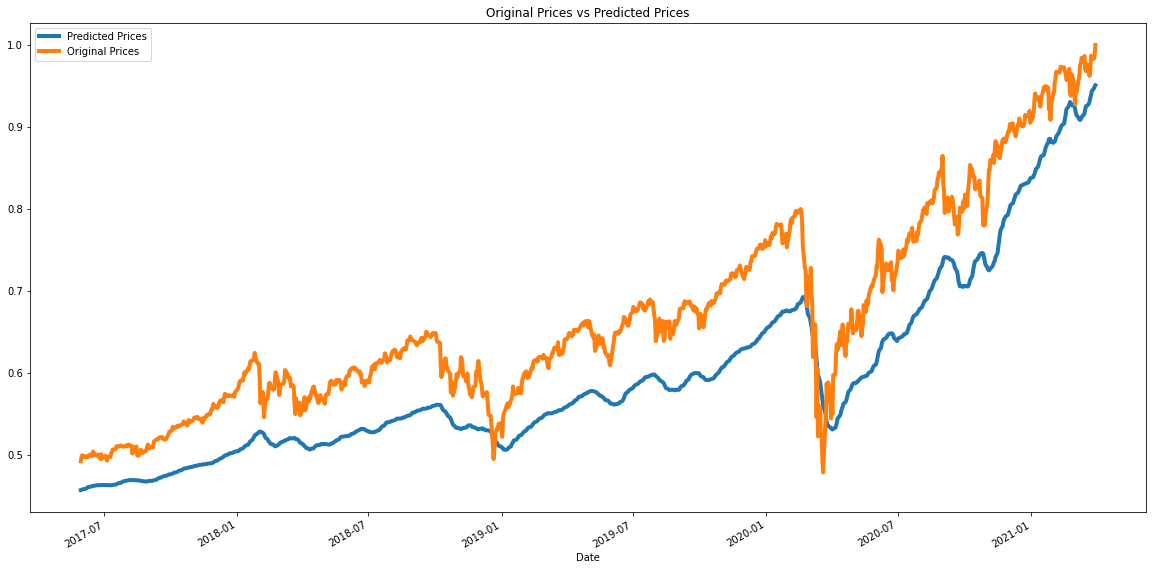

In [715]:
#Using pyplot to compare the original and predicted prices
predictionDF.plot(x = 'Date', figsize = (20, 10), linewidth = 4, 
             title = 'Original Prices vs Predicted Prices')

#Experiment with the lookback period, the further back you go, the least accurate it gets.